In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.plot import show

In [3]:
# Load a shapefile metadata sample
shapefile_path = "/gypsum/scratch1/jtaneja/DG/DG_new/AOP_AF17_Q317_V0_502_314_126_9/metadata_AOP_AF17_Q317_V0_502_102333230_3.shp"
shapes_df = gpd.read_file(shapefile_path)

In [5]:
shapes_df.head()

,FILENAME,CATALOG_ID,ACQ_DATE,ONA,CC,SUNEL,SENSOR,ACCURACY,TILE_TYPE,VERSION,geometry
0,AOP_AF17_Q317_V0_502_314_126_9/AOP_AF17_Q317_V...,1050010004CB5400,2016-06-13,23.982647,3.0225,56.891247,GE01,10.2,SVA,AOP-Processing_1.1.8.1,"POLYGON ((41.17918 -0.87891, 41.22070 -0.87891..."
1,AOP_AF17_Q317_V0_502_314_126_9/AOP_AF17_Q317_V...,1030010052215A00,2016-02-18,25.263866,0.7160,63.230797,WV02,10.2,SVA,AOP-Processing_1.1.8.1,"POLYGON ((41.13281 -0.87891, 41.17874 -0.87891..."
2,AOP_AF17_Q317_V0_502_314_126_9/AOP_AF17_Q317_V...,1050010004CB5400,2016-06-13,23.982647,8.5935,56.891247,GE01,10.2,SVA,AOP-Processing_1.1.8.1,"POLYGON ((41.22070 -0.87891, 41.22796 -0.87891..."
3,AOP_AF17_Q317_V0_502_314_126_9/AOP_AF17_Q317_V...,103001001B58CE00,2012-09-04,29.471790,4.8735,74.805695,WV02,10.2,SVA,AOP-Processing_1.1.8.1,"POLYGON ((41.22805 -0.96680, 41.22784 -0.96680..."
4,AOP_AF17_Q317_V0_502_314_126_9/AOP_AF17_Q317_V...,103001001D0FFB00,2013-01-10,15.170404,2.6667,61.510864,WV02,10.2,SVA,AOP-Processing_1.1.8.1,"POLYGON ((41.22070 -0.97654, 41.22070 -0.97709..."


In [31]:
# let's look at the first filename and see if there are multiple entries in the metadata file
shapes_df.iloc[56,0]

'AOP_AF17_Q317_V0_502_314_126_9/AOP_AF17_Q317_V0_502_314_126_9_R6C1.tif'

In [32]:
shapes_df[shapes_df.FILENAME == 'AOP_AF17_Q317_V0_502_314_126_9/AOP_AF17_Q317_V0_502_314_126_9_R6C1.tif']

,FILENAME,CATALOG_ID,ACQ_DATE,ONA,CC,SUNEL,SENSOR,ACCURACY,TILE_TYPE,VERSION,geometry
55,AOP_AF17_Q317_V0_502_314_126_9/AOP_AF17_Q317_V...,10300100620D8100,2017-01-11,27.210800,0.0,58.913303,WV02,10.2,SVA,AOP-Processing_1.1.8.1,"POLYGON ((40.84239 -1.14258, 40.86914 -1.14258..."
56,AOP_AF17_Q317_V0_502_314_126_9/AOP_AF17_Q317_V...,1030010064D33700,2017-01-11,23.061316,0.0,58.808212,WV02,10.2,SVA,AOP-Processing_1.1.8.1,"POLYGON ((40.84067 -1.23036, 40.84068 -1.23036..."


As we can see, the metadata contains multiple entries from the same mosaic, but have different acquisition dates, sensors and geometries.
We can extract these geometries and use the SENSOR as a label to infer the GSD.

In [34]:
# Load the satellite image that correspond to the metadata entry above
image_path = "/gypsum/scratch1/jtaneja/DG/DG_new/AOP_AF17_Q317_V0_502_314_126_9/AOP_AF17_Q317_V0_502_314_126_9_R6C1.tif"
with rasterio.open(image_path) as src:
    image = src.read()

# Extract the geometry of the shapefile
# geometry = shapes_df.geometry.unary_union
geometry1 = shapes_df[shapes_df.FILENAME == 'AOP_AF17_Q317_V0_502_314_126_9/AOP_AF17_Q317_V0_502_314_126_9_R3C5.tif'].head(1).geometry
geometry2 = shapes_df[shapes_df.FILENAME == 'AOP_AF17_Q317_V0_502_314_126_9/AOP_AF17_Q317_V0_502_314_126_9_R3C5.tif'].tail(1).geometry

In [35]:
geometry1

0    POLYGON ((41.17918 -0.87891, 41.22070 -0.87891...
Name: geometry, dtype: geometry

In [36]:
geometry2

1    POLYGON ((41.13281 -0.87891, 41.17874 -0.87891...
Name: geometry, dtype: geometry

<AxesSubplot:>

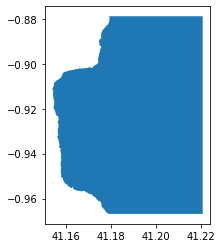

In [37]:
geometry1.plot()

<AxesSubplot:>

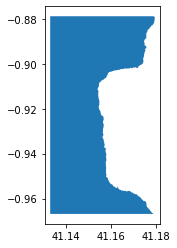

In [38]:
geometry2.plot()

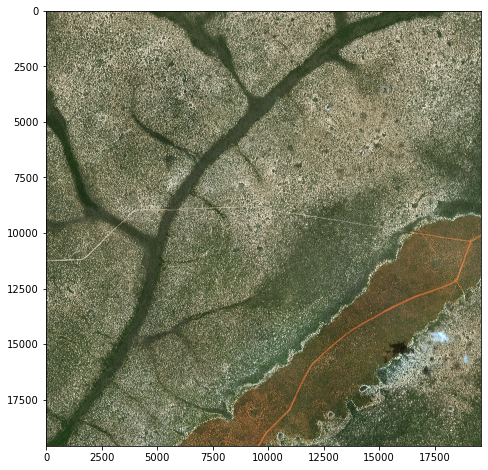

<AxesSubplot:>

In [39]:
plt.figure(figsize=(8, 8))
show(image)

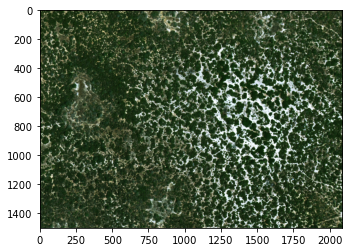

<AxesSubplot:>

In [30]:
#let's look to a subset
show(image[:,12500:14000, 17500:])

In [42]:
shapes_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [43]:
src.crs

CRS.from_epsg(4326)

In [ ]:
# Crop the image based on the shapefile extent
cropped_image1, cropped_transform1 = mask(src, geometry1.values, crop=True)

# Crop the image based on the shapefile extent
cropped_image2, cropped_transform2 = mask(src, geometry2.values, crop=True)

In [44]:
import fiona
import rasterio
import rasterio.mask

with fiona.open("/gypsum/scratch1/jtaneja/DG/DG_new/AOP_AF17_Q317_V0_502_314_126_9/metadata_AOP_AF17_Q317_V0_502_102333230_3.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

In [45]:
len(shapes)

188

In [48]:
with rasterio.open("/gypsum/scratch1/jtaneja/DG/DG_new/AOP_AF17_Q317_V0_502_314_126_9/AOP_AF17_Q317_V0_502_314_126_9_R6C1.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, [shapes[55]], crop=True)
    out_meta = src.meta

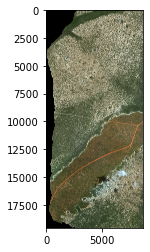

<AxesSubplot:>

In [49]:
show(out_image)